<a href="https://colab.research.google.com/github/stemlock/w266_final_project/blob/master/Data_Preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
CWD = '/content/drive/My Drive/W266 Final Project/Code'

%cd $CWD

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/W266 Final Project/Code


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Set random seed
seed = 42

In [4]:
# Set the paths to save the preprocessed train and test data
train_path = 'data/preprocessed_train.csv'
test_path = 'data/preprocessed_test.csv'

In [ ]:
# SHOULD NOT BE RUN IN A COLAB NOTEBOOK. IF DATA NEEDS TO BE PREPROCESSED, PLEASE RUN THESE COMMANDS LOCALLY FIRST
# # Preprocess data in script to create neutral and gendered versions
# !python3 preprocess.py -d 'data/aclImdb/train/' -v 'wordlist/' -o $train_path
# !python3 preprocess.py -d 'data/aclImdb/test/' -v 'wordlist/' -o $test_path

In [6]:
# Read in processed data (Rows with NA in the neutral_review_text had no tokens replaced)
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)
df_train.head()

,review_id,review_score,review_text,neutral_review_text,neutral_sub_count,female_review_text,female_sub_count,male_review_text,male_sub_count,label
0,4715,9,For a movie that gets no respect there sure ar...,NaN,0,for a movie that gets no respect there sure ar...,0,for a movie that gets no respect there sure ar...,0,1
1,12390,8,Bizarre horror movie filled with famous faces ...,bizarre horror movie filled with famous faces ...,2,bizarre horror movie filled with famous faces ...,1,bizarre horror movie filled with famous faces ...,1,1
2,8329,7,"A solid, if unremarkable film. Matthau, as Ein...",NaN,0,"a solid, if unremarkable film. matthau, as ein...",0,"a solid, if unremarkable film. matthau, as ein...",0,1
3,9063,8,It's a strange feeling to sit alone in a theat...,it's a strange feeling to sit alone in a theat...,13,it's a strange feeling to sit alone in a theat...,12,it's a strange feeling to sit alone in a theat...,1,1
4,3092,10,"You probably all already know this by now, but...","you probably all already know this by now, but...",2,"you probably all already know this by now, but...",1,"you probably all already know this by now, but...",1,1


In [22]:
# # Check that the number of UNK tokens is the same as neutral sub count for train and test
# print("Train:", (df_train['neutral_review_text'].str.count('\[UNK\]').fillna(0) == df_train['neutral_sub_count']).unique())
# print("Test:", (df_test['neutral_review_text'].str.count('\[UNK\]').fillna(0) == df_test['neutral_sub_count']).unique())

Train: [ True]
Test: [ True]


In [24]:
# # Check that the male + female sub counts add up to neutral in train
# print("Train:", (df_train['neutral_sub_count'] == (df_train['female_sub_count'] + df_train['male_sub_count'])).unique())
# print("Test:", (df_test['neutral_sub_count'] == (df_test['female_sub_count'] + df_test['male_sub_count'])).unique())

Train: [ True]
Test: [ True]


In [25]:
# Check how many reviews had no replacement tokens
print("Nongendered reviews in train:", df_train['neutral_review_text'].isna().sum())
print("Nongendered reviews in test:", df_test['neutral_review_text'].isna().sum())

Nongendered reviews in train: 4058
Nongendered reviews in test: 4112


In [26]:
# Isolate the nongendered reviews 
df_nongendered = df_train[df_train['neutral_review_text'].isna()]

In [27]:
# Check the balance of review scores in the original train set
df_train['review_score'].value_counts()/len(df_train['review_score'])

1     0.20400
10    0.18928
8     0.12036
4     0.10784
7     0.09984
3     0.09680
2     0.09136
9     0.09052
Name: review_score, dtype: float64

In [28]:
# Check the balance of review scores in the nongendered reviews
df_nongendered['review_score'].value_counts()/len(df_nongendered['review_score'])

1     0.252341
10    0.235584
8     0.098078
9     0.092656
2     0.089699
4     0.088467
3     0.079842
7     0.063332
Name: review_score, dtype: float64

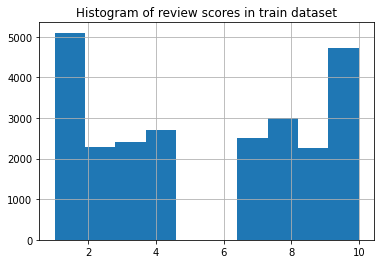

In [29]:
# Check the distribution of the review scores in train
df_train.hist(column='review_score')
plt.title("Histogram of review scores in train dataset")
plt.show()

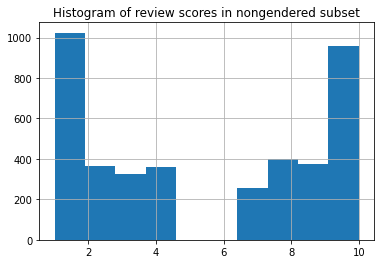

In [30]:
# Check the distribution of the review scores in nongendered reviews
df_nongendered.hist(column='review_score')
plt.title("Histogram of review scores in nongendered subset")
plt.show()

In [31]:
# Drop all nongendered rows in train by checking the neutral_review_text column
df_train.dropna(inplace=True)
print("Number of rows left in train:", df_train.shape[0])
print("Class balance:")
print(df_train['label'].value_counts())
print(df_train['label'].value_counts()/df_train.shape[0])

Number of rows left in train: 20942
Class balance:
1    10513
0    10429
Name: label, dtype: int64
1    0.502006
0    0.497994
Name: label, dtype: float64


In [32]:
# Drop all nongendered rows in test by checking the neutral_review_text column
df_test.dropna(inplace=True)
print("Number of rows left in test:", df_test.shape[0])
print("Class balance:")
print(df_test['label'].value_counts())
print(df_test['label'].value_counts()/df_test.shape[0])

Number of rows left in test: 20888
Class balance:
0    10501
1    10387
Name: label, dtype: int64
0    0.502729
1    0.497271
Name: label, dtype: float64


In [33]:
# Perform stratified sample on both test and train to get new train and test split data
split_frac = 0.8
df_all = pd.concat([df_test,df_train], ignore_index=True)
df_train_new = df_all.groupby('review_score', group_keys=False).apply(lambda x: x.sample(frac=split_frac, random_state=seed))
df_test_new = df_all[~df_all.index.isin(df_train_new.index)]
df_train_new

,review_id,review_score,review_text,neutral_review_text,neutral_sub_count,female_review_text,female_sub_count,male_review_text,male_sub_count,label
41211,6990,1,What the hell is this? Its one of the dumbest ...,what the hell is this? its one of the dumbest ...,1,what the hell is this? its one of the dumbest ...,1,what the hell is this? its one of the dumbest ...,0,0
34899,12145,1,"As you may have gathered from the title, I who...","as you may have gathered from the title, i who...",8,"as you may have gathered from the title, i who...",7,"as you may have gathered from the title, i who...",1,0
14084,7457,1,"This Canadian ""movie"" is the worst ever! Stunn...","this canadian ""movie"" is the worst ever! stunn...",7,"this canadian ""movie"" is the worst ever! stunn...",5,"this canadian ""movie"" is the worst ever! stunn...",2,0
34596,7324,1,Being a Film studies graduate I would like to ...,being a film studies graduate i would like to ...,2,being a film studies graduate i would like to ...,1,being a film studies graduate i would like to ...,1,0
41142,7089,1,A sexually obsessed chef leads a duplicitous l...,a sexually obsessed chef leads a duplicitous l...,7,a sexually obsessed chef leads a duplicitous l...,4,a sexually obsessed chef leads a duplicitous l...,3,0
...,...,...,...,...,...,...,...,...,...,...
22892,2130,10,"A wonderful film, filled with great understate...","a wonderful film, filled with great understate...",3,"a wonderful film, filled with great understate...",2,"a wonderful film, filled with great understate...",1,1
24852,4521,10,Julie Waters is always marvelous but Adrian Pa...,julie waters is always marvelous but adrian pa...,3,julie waters is always marvelous but adrian pa...,3,julie waters is always marvelous but adrian pa...,0,1
3641,805,10,This is an absolutely true and faithful adapta...,this is an absolutely true and faithful adapta...,7,this is an absolutely true and faithful adapta...,3,this is an absolutely true and faithful adapta...,4,1
30063,10849,10,This is perhaps the best rockumentary ever- a ...,this is perhaps the best rockumentary ever- a ...,1,this is perhaps the best rockumentary ever- a ...,0,this is perhaps the best rockumentary ever- a ...,1,1


In [34]:
# Check that train/test split does not have any spillover
print("Check if length of all rows equals train + test rows:", (len(df_train_new) + len(df_test_new)) == len(df_all))
print("Check if there are any overlapping data:", len(set(df_test_new.index) & set(df_train_new.index)))
print(f"Check train, test split ratio: {len(df_train_new)/len(df_all)}, {len(df_test_new)/len(df_all)}" )

Check if length of all rows equals train + test rows: True
Check if there are any overlapping data: 0
Check train, test split ratio: 0.8, 0.2


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f82ffeb3310>]],
      dtype=object)

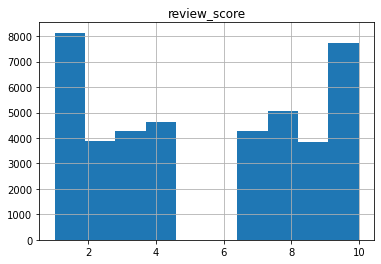

In [35]:
# Original distribution
df_all.hist(column='review_score')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f82ff88ec50>]],
      dtype=object)

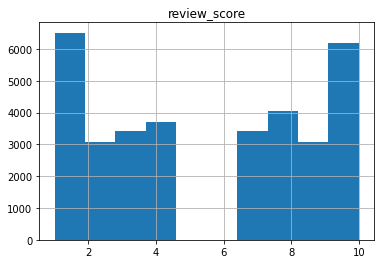

In [36]:
# New train distribution
df_train_new.hist(column='review_score')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f82ff7d3390>]],
      dtype=object)

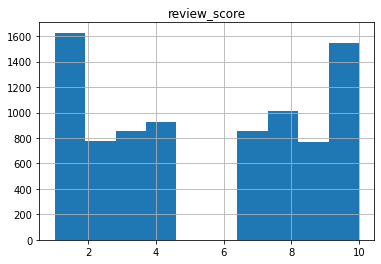

In [37]:
# New test distribution
df_test_new.hist(column='review_score')

In [38]:
# Save the newly transformed data 
df_train_new.to_csv('data/model_train.csv', index=False)
df_test_new.to_csv('data/model_test.csv', index=False)